<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/main/6_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle series. Spaceship titanic

# Imports


## Packages

In [94]:
# colab
from google.colab import drive

# data
import pandas as pd
pd.set_option('display.max_columns', None)

# math
import numpy as np

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt

## PEP8 code standard

In [2]:
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

## Importing custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

git_download_path = \
    'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers

def reload_modules(modules):
    for module in modules:
        importlib.reload(module)

reload_modules(
    [
        path_manager,
        sklearn_transformers,
        sklearn_utils
    ]
)

from path_manager import PathManager
from sklearn_transformers import ColumnDropper
from sklearn_utils import inf_statistics
from sklearn_transformers import OutlierCleaner

# Set up paths

In [5]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 'Demo'
MODELS_TRIAL = 'Demo'
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive


# Download the data

In [6]:
df_train = pd.read_csv(manager.train_path, index_col='Unnamed: 0')
df_test = pd.read_csv(manager.test_path, index_col='Unnamed: 0')

# Checking NAN & Infinity values

In [7]:
from sklearn_utils import (
    nan_statistics,
    inf_statistics
)

In [9]:
_ = nan_statistics(df_train)
print('')
_ = nan_statistics(df_test)

Col -- Nan percentage
CryoSleep 2.4962613597147127
ShoppingMall 2.392729782583688
VIP 2.3352122397331185
HomePlanet 2.312205222592891
Name 2.300701714022777
Cabin 2.289198205452663
VRDeck 2.1626596111814105
FoodCourt 2.105142068330841
Spa 2.105142068330841
Destination 2.093638559760727
RoomService 2.082135051190613
Age 2.0591280340503855

Col -- Nan percentage
FoodCourt 2.4783726911386488
Spa 2.3614683189151275
Cabin 2.338087444470423
ShoppingMall 2.2913256955810146
Name 2.197802197802198
CryoSleep 2.1744213233574934
VIP 2.1744213233574934
Destination 2.1510404489127897
Age 2.127659574468085
HomePlanet 2.034136076689268
RoomService 1.917231704465747
VRDeck 1.8704699555763384


In [10]:
_ = inf_statistics(df_train)
print('')
_ = inf_statistics(df_test)

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
gender          0
dtype: int64

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
gender          0
dtype: int64


# Feature engineering

## Has someone bought any luxury service?

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin


class BoughtLuxuryItems(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['BoughtAnyLuxury'] = \
            (transformed_df['ShoppingMall'] > 0.0) \
            | (transformed_df['FoodCourt'] > 0.0) \
            | (transformed_df['VRDeck'] > 0.0) \
            | (transformed_df['Spa'] > 0.0) \
            | (transformed_df['RoomService'] > 0.0)
        transformed_df['BoughtAnyLuxury'] = \
            transformed_df['BoughtAnyLuxury'].astype('int')
        return transformed_df


pep8(_ih)

In [12]:
bought_luxury_items = BoughtLuxuryItems()

df_train = bought_luxury_items.fit_transform(df_train)
df_test = bought_luxury_items.transform(df_test)

## DeckNum, DeckSide, Deck

In [13]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckNumAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_deck_num(self, deck):
        if type(deck) is str:
            split_items = deck.split('/')
            return int(split_items[1])
        else:
            return np.nan

    def transform(self, X, y=None):
        df_transformed = X.copy()
        df_transformed['DeckNum'] = df_transformed['Cabin'] \
            .map(self.get_deck_num)
        return df_transformed


pep8(_ih)

In [15]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckSideAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def add_deck_side(self, val):
        if type(val) is str:
            return val.split('/')[2]
        else:
            return np.nan

    def transform(self, X, y=None):
        df_transformed = X.copy()
        df_transformed['DeckSide'] = df_transformed['Cabin'].map(
            self.add_deck_side)

        del X
        return df_transformed


pep8(_ih)

In [16]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def add_deck(self, val):
        if type(val) is str:
            return val.split('/')[0]
        else:
            return np.nan

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['Deck'] = transformed_df['Cabin'].map(
            self.add_deck
        )
        del X
        return transformed_df


pep8(_ih)

In [17]:
deck_num_adder = DeckNumAdder()

df_train = deck_num_adder.fit_transform(df_train)
df_test = deck_num_adder.transform(df_test)

In [18]:
deck_side_adder = DeckSideAdder()

df_train = deck_side_adder.fit_transform(df_train)
df_test = deck_side_adder.transform(df_test)

In [19]:
deck_adder = DeckAdder()

df_train = deck_adder.fit_transform(df_train)
df_test = deck_adder.transform(df_test)

## Passenger group, passenger position. Is a passenger single in the group? What is the group size?

In [20]:
from sklearn.base import TransformerMixin, BaseEstimator


class PassengerGroupAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_passenger_group(self, val):
        if val is not np.nan:
            return int(val.split('_')[0])
        else:
            return val

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['PassengerGroup'] = \
            X['PassengerId'].map(self.get_passenger_group)
        del X
        return transformed_df


pep8(_ih)

In [24]:
from sklearn.base import TransformerMixin, BaseEstimator


class PassengerPositionAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_position(self, val):
        if type(val) is str:
            return int(val.split('_')[1])
        else:
            return np.nan

    def transform(self, X, y=None):
        # df_transformed = X.copy()
        # del X
        X['PassengerGroupPosition'] = \
            X['PassengerId'].map(self.get_position)
        return X


pep8(_ih)

In [30]:
from sklearn.base import TransformerMixin, BaseEstimator


class GroupSizeAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.value_counts = None

    def fit(self, X, y=None):
        self.value_counts = X['PassengerGroup'].value_counts()
        return self

    def get_group_size(self, val):
        return self.value_counts.loc[val]

    def transform(self, X, y=None):
        X['GroupSize'] = \
            X['PassengerGroup'].map(self.get_group_size)
        X['AloneInGroup'] = (X['GroupSize'] == 1).astype('int')
        return X


pep8(_ih)

In [31]:
group_adder = PassengerGroupAdder()

df_train = group_adder.fit_transform(df_train)
df_test = group_adder.transform(df_test)

In [32]:
position_adder = PassengerPositionAdder()

df_train = position_adder.fit_transform(df_train)
df_test = position_adder.transform(df_test)

In [33]:
adder = GroupSizeAdder()
df_train = adder.fit_transform(df_train)

# Fit transform on test, because
# contains group numbers, not present in df_train
df_test = adder.fit_transform(df_test)

## Total spend

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin


class TotalSpender(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cols_list = [
            'Spa',
            'FoodCourt',
            'VRDeck',
            'RoomService',
            'ShoppingMall'
        ]
        X_temp = X \
            .loc[:, cols_list] \
            .fillna(X.loc[:, cols_list].median())

        X['TotalSpend'] = \
            X_temp['Spa'] \
            + X_temp['FoodCourt'] \
            + X_temp['VRDeck'] \
            + X_temp['RoomService'] \
            + X_temp['ShoppingMall']
        X['ZeroSpend'] = (X['TotalSpend'] <= 0).astype('int')
        return X


pep8(_ih)

In [37]:
total_spend_adder = TotalSpender()

df_train = total_spend_adder.fit_transform(df_train)
df_test = total_spend_adder.transform(df_test)

## Total spend categorization (binning)

In [38]:

def categorize_total_spend(dfs_):
    for df_ in dfs_:
        df_['SpendCategory'] = ''
        df_.loc[df_['TotalSpend'].between(-1, 1, 'left'), 'SpendCategory'] = \
            'ZeroSpend'
        df_.loc[df_['TotalSpend'].between(1, 800, 'both'), 'SpendCategory'] = \
            'Under800'
        df_.loc[df_['TotalSpend'].between(800, 1200, 'right'), 'SpendCategory'] = \
            'Median1200'
        df_.loc[df_['TotalSpend'].between(1200, 2700, 'right'), 'SpendCategory'] = \
            'Upper2700'
        df_.loc[df_['TotalSpend'].between(2700, 100000, 'right'), 'SpendCategory'] = \
            'BigSpender'

        df_['SpendCategory'] = \
            df_['SpendCategory'].astype('category')

categorize_total_spend([df_train, df_test])

In [39]:
df_train.SpendCategory.value_counts(dropna=False)

ZeroSpend     3653
Under800      1274
Upper2700     1274
Median1200    1261
BigSpender    1231
Name: SpendCategory, dtype: int64

## Age categorization (binning)

In [40]:
def categorize_age(dfs_):
    # -1, 5 - is a specific range,
    # 70% probability of being transported
    # for the kids in this range
    bins = [-1, 5, 18, 30, 50, 100]
    labels = [i for i in range(len(bins) - 1)]
    for df in dfs_:
        df['AgeGroup'] = pd.cut(
            df['Age'].fillna(df['Age'].median()),
            bins=bins,
            labels=labels,
            duplicates='drop'
        )

categorize_age([df_train, df_test])

In [42]:
assert 'AgeGroup' in df_train.columns and 'AgeGroup' in df_test.columns

df_train.AgeGroup.value_counts(normalize=True, dropna=False)

2    0.393075
3    0.307604
1    0.157138
4    0.084781
0    0.057403
Name: AgeGroup, dtype: float64

## Total spend per group

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin


class PerGroupSpender(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.total_spend_per_group_data = {}

    def fit(self, X, y=None):
        # self.total_spend_per_group_data = \
        #     X \
        #     .groupby('PassengerGroup') \
        #     .aggregate('sum') \
        #     .loc[:, ['TotalSpend']]
        unique_groups = X['PassengerGroup'].unique()

        for unique_group in unique_groups:
            group_subset = X.loc[
                X['PassengerGroup'] == unique_group,
                ['TotalSpend']
            ]
            total_spend_per_group = \
                group_subset.fillna(group_subset.median()).sum() \
                / len(group_subset)

            self.total_spend_per_group_data[unique_group] = \
                total_spend_per_group
        return self

    def transform(self, X, y=None):
        X['TotalSpendPerGroup'] = \
            X['PassengerGroup'].map(
                lambda val: self.total_spend_per_group_data[val][0])
        return X


pep8(_ih)

In [44]:
per_group_spender = PerGroupSpender()

df_train = per_group_spender.fit_transform(df_train)

# Yes, fit_transform on the test data, because
# test set can contain other groups
df_test = per_group_spender.fit_transform(df_test)

## Does a person come from a spendless group?

In [45]:
feature = 'IsFromSpendlessGroup'
df_train[feature] = (df_train['TotalSpendPerGroup'] == 0).astype('int')
df_test[feature] = (df_test['TotalSpendPerGroup'] == 0).astype('int')

## Group size categorization (binning)

In [48]:

def categorize(dfs_):
    bins = [0, 3, 6, 10]
    labels = [i for i in range(len(bins) - 1)]
    for df in dfs_:
        df['GroupSizeCat'] = \
            pd.cut(
                df['GroupSize'],
                bins=bins,
                labels=labels,
                duplicates='drop')


categorize([df_train, df_test])
pep8(_ih)

# Clean outliers

In [49]:
from sklearn_transformers import OutlierCleaner

columns_to_clean = [
        'VRDeck',
        'Spa',
        'RoomService',
        'FoodCourt',
        'ShoppingMall',
        'TotalSpend',
        'TotalSpendPerGroup',
        'Age'
]

cleaner = OutlierCleaner(
    columns_to_clean,
    lower_quantile_=0.05,
    upper_quantile_=0.95
)

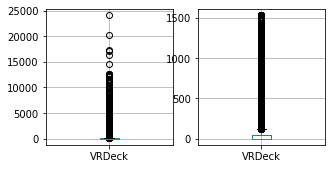

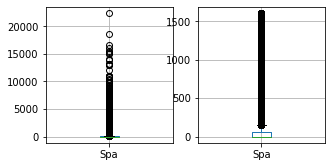

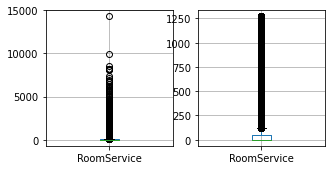

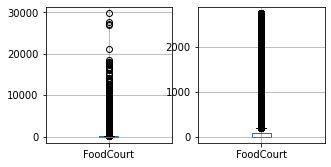

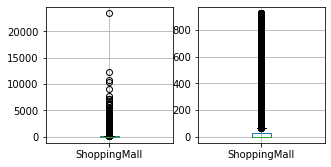

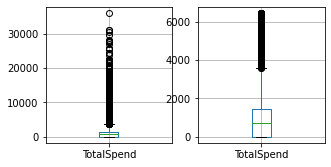

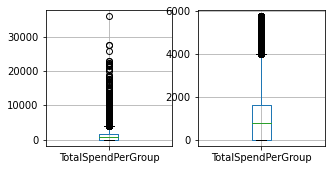

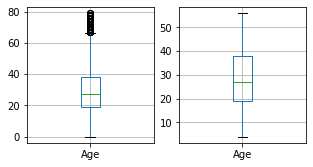

In [60]:
df_result = cleaner.fit_transform(df_train)

for column in columns_to_clean:
    fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
    df_train.boxplot([column], ax=ax[0])
    df_result.boxplot([column], ax=ax[1])

In [61]:
df_train = cleaner.fit_transform(df_train)
df_test = cleaner.transform(df_test)

# Reducing number precision

In [63]:

def reduce_precision(
    df_,
    original_dtypes_=['float64'],
    transcription_dict_={
        'float64': 'float32',
        'int64': 'int32'
    }
):
    '''
    For every column, that has a dtype in original_dtypes
    list --> it changes the original dtype, according to
    the transcription_dict_
    '''
    for numeric_type in original_dtypes_:
        mask = np.isin(df_.dtypes, [numeric_type])
        df_.loc[:, mask] = \
            df_.loc[:, mask].astype(transcription_dict_[numeric_type])
    return df_


pep8(_ih)

- Was not considered for this task

# Removing NaN / Inf columns

None of the columns contain significant percentage of NaN / Inf values, hence removal was not considered for this task

In [65]:
_ = nan_statistics(df_train)
print()
_ = nan_statistics(df_test)

Col -- Nan percentage
CryoSleep 2.4962613597147127
ShoppingMall 2.392729782583688
VIP 2.3352122397331185
HomePlanet 2.312205222592891
Name 2.300701714022777
Cabin 2.289198205452663
DeckNum 2.289198205452663
DeckSide 2.289198205452663
Deck 2.289198205452663
VRDeck 2.1626596111814105
FoodCourt 2.105142068330841
Spa 2.105142068330841
Destination 2.093638559760727
RoomService 2.082135051190613
Age 2.0591280340503855

Col -- Nan percentage
FoodCourt 2.4783726911386488
Spa 2.3614683189151275
Cabin 2.338087444470423
DeckNum 2.338087444470423
DeckSide 2.338087444470423
Deck 2.338087444470423
ShoppingMall 2.2913256955810146
Name 2.197802197802198
CryoSleep 2.1744213233574934
VIP 2.1744213233574934
Destination 2.1510404489127897
Age 2.127659574468085
HomePlanet 2.034136076689268
RoomService 1.917231704465747
VRDeck 1.8704699555763384


# Data processing pipeline

In [90]:
luxury_columns = [
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'TotalSpend',
    'TotalSpendPerGroup'
]

luxury_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('standardize', StandardScaler())
    ]
)

In [67]:
spend_category_columns = [
    'SpendCategory'
]

spend_category_pipeline = Pipeline(
    [
        ('encode', OrdinalEncoder(
            categories = [
                [
                    'ZeroSpend',
                    'Under800',
                    'Median1200',
                    'Upper2700',
                    'BigSpender'
                ]
            ]
        )),
        ('scale', MinMaxScaler())
    ]
)

In [68]:
age_group_columns = [
    'AgeGroup'
]

age_group_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('Scale', MinMaxScaler())
    ]
)

In [69]:
is_from_spendless_group_columns = [
    'IsFromSpendlessGroup'
]

is_from_spendless_group_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [70]:
name_columns = [
    'Name'
]

name_pipeline = Pipeline(
    [
        ('drop', ColumnDropper(name_columns))
    ]
)

In [71]:
age_columns = [
    'Age'
]

age_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('standardize', StandardScaler())
    ]
)

In [72]:
home_planet_columns = [
    'HomePlanet'
]

home_planet_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(missing_values=np.nan, strategy='constant')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [73]:
destination_columns = [
    'Destination'
]

destination_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(strategy='median')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [74]:
passenger_id_columns = [
    'PassengerId'
]

passenger_id_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(strategy='median')),
        ('drop', ColumnDropper(passenger_id_columns))
    ]
)

In [75]:
cabin_columns = [
    'Cabin'
]

cabin_pipeline = Pipeline(
    [
        ('drop', ColumnDropper(cabin_columns))
    ]
)

In [76]:
cryo_sleep_columns = [
    'CryoSleep'
]

cryo_sleep_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [77]:
vip_columns = [
    'VIP'
]

vip_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [78]:
bought_any_luxury_columns = [
    'BoughtAnyLuxury'
]

bought_any_luxury_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
    ]
)

In [79]:
deck_columns = [
    'Deck'
]

deck_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        (
            'encode',
            OrdinalEncoder(
                categories=[
                    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
                ]
            )
        ),
        ('scale', MinMaxScaler())
    ]
)

In [80]:
deck_num_columns = [
    'DeckNum'
]

deck_num_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)

In [81]:
deck_size_columns = [
    'DeckSide'
]

deck_side_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [82]:
alone_columns = ['AloneInGroup']
alone_pipeline = Pipeline(
    [('impute', SimpleImputer(strategy='most_frequent'))]
)

In [83]:
group_position_columns = ['PassengerGroupPosition']
group_position_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('scale', StandardScaler())
    ]
)

In [84]:
group_size_columns = ['GroupSize']
group_size_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)

In [85]:
passenger_group_columns = ['PassengerGroup']
passenger_group_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)

In [86]:
gender_columns = ['gender']
gender_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [87]:
group_size_cat_columns = [
    'GroupSizeCat'
]

group_size_cat_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('scale', MinMaxScaler())
        # ('encode', )  # already encoded
    ]
)

In [88]:
zero_spend_columns = [
    'ZeroSpend'
]

zero_spend_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent'))
    ]
)

In [91]:
all_columns = set(
    [
        *luxury_columns,
        *name_columns,
        *age_columns,
        *home_planet_columns,
        *destination_columns,
        *passenger_id_columns,
        *cabin_columns,
        *vip_columns,
        *cryo_sleep_columns,
        *bought_any_luxury_columns,
        *deck_columns,
        *deck_num_columns,
        *deck_size_columns,
     
        *alone_columns,
        *group_position_columns,
        *group_size_columns,
        *passenger_group_columns,
        *gender_columns,
     
        *spend_category_columns,
        *age_group_columns,
        *is_from_spendless_group_columns,
     
        *group_size_cat_columns,
        *zero_spend_columns
    ]
)

# print(df_train.columns)
assert (set(df_train.columns) - all_columns) == {'Transported'}, \
    print(set(df_train.columns) - all_columns)

In [92]:
from sklearn_transformers import ColumnDropper


preprocessor = ColumnTransformer(
    [
        ('luxury', luxury_pipeline, luxury_columns),
        ('drop', name_pipeline, name_columns),
        ('age', age_pipeline, age_columns),
        ('home_planet', home_planet_pipeline, home_planet_columns),
        ('destination', destination_pipeline, destination_columns),
        ('passenger_id', passenger_id_pipeline, passenger_id_columns),
        ('name', name_pipeline, name_columns),
        ('vip', vip_pipeline, vip_columns),
        ('cryo_sleep', cryo_sleep_pipeline, cryo_sleep_columns),
        ('cabin', cabin_pipeline, cabin_columns),
        
        ('bought_any_luxury', bought_any_luxury_pipeline, bought_any_luxury_columns),
        ('deck', deck_pipeline, deck_columns),
        ('deck_num', deck_num_pipeline, deck_num_columns),
        ('deck_side', deck_side_pipeline, deck_size_columns),
        
        ('alone_in_group', alone_pipeline, alone_columns),
        ('passenger_group_position', group_position_pipeline, group_position_columns),
        ('passenger_group', passenger_group_pipeline, passenger_group_columns),
        ('gender', gender_pipeline, gender_columns),
     
        ('group_size', group_size_pipeline, group_size_columns),
        ('group_size_cat', group_size_cat_pipeline, group_size_cat_columns),
        ('zero_spend', zero_spend_pipeline, zero_spend_columns),
        ('spend_category', spend_category_pipeline, spend_category_columns),
        ('age_group', age_group_pipeline, age_group_columns),
        ('is_from_spendless_group', is_from_spendless_group_pipeline,
            is_from_spendless_group_columns),

        ('transported', 'passthrough', ['Transported'])
    ],
    remainder='drop'
)

# Split data into train, validation and test sets

## Split

In [95]:
TRAIN_VAL_PERCENTAGE = 0.8
RANDOM_STATE = 42

df_trainval, df_test_sample = train_test_split(
    df_train,
    train_size=TRAIN_VAL_PERCENTAGE,
    random_state=RANDOM_STATE,
    stratify=df_train['Transported']
)

df_trainval.shape, df_test_sample.shape

((6954, 30), (1739, 30))

## Check class and feature distribution

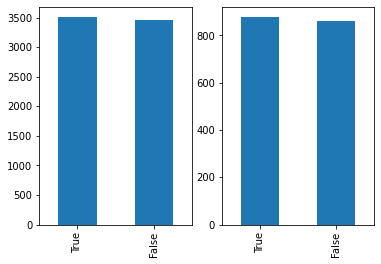

In [100]:
_, ax = plt.subplots(1, 2)
df_trainval.Transported.value_counts().plot(ax=ax[0], kind='bar')
df_test_sample.Transported.value_counts().plot(ax=ax[1], kind='bar')

In [102]:
df_trainval.dtypes

PassengerId                 object
HomePlanet                  object
CryoSleep                   object
Cabin                       object
Destination                 object
Age                        float64
VIP                         object
RoomService                float64
FoodCourt                  float64
ShoppingMall               float64
Spa                        float64
VRDeck                     float64
Name                        object
Transported                   bool
gender                       int64
BoughtAnyLuxury              int64
DeckNum                    float64
DeckSide                    object
Deck                        object
PassengerGroup               int64
PassengerGroupPosition       int64
GroupSize                    int64
AloneInGroup                 int64
TotalSpend                 float64
ZeroSpend                    int64
SpendCategory             category
AgeGroup                  category
TotalSpendPerGroup         float64
IsFromSpendlessGroup

Visualizing datasets distributions


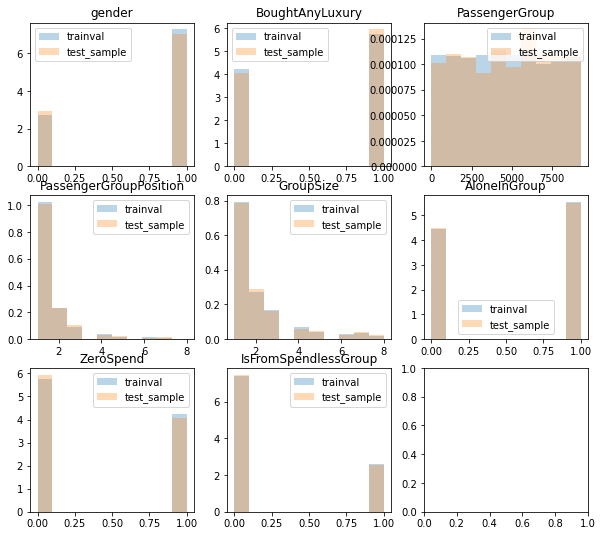

In [101]:
from sklearn_utils import visualize_datasets_distributions


visualize_datasets_distributions(
    dataframes_dict_={
        'trainval': df_trainval,
        'test_sample': df_test_sample
    },
    columns_=df_trainval.columns[np.isin(df_trainval.dtypes, ['float32', 'int', ''])]
)

# Process the datasets

In [103]:
df_trainval_processed = preprocessor \
    .fit_transform(df_trainval) \
    .astype('float64')

col_n = -1
assert (df_trainval_processed[:, col_n] == df_trainval['Transported']).all()

In [104]:
pd.DataFrame(df_trainval_processed).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.689617,-0.587588,-1.826866,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.857143,0.071038,0.0,1.0,0.0,2.392570,-0.277637,1.0,3.130413,1.0,1.0,0.0,0.00,0.0,1.0
1,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.689617,-0.806212,-0.857321,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.857143,-0.777867,0.0,1.0,1.0,-0.490454,-1.226031,1.0,-0.650221,0.0,1.0,0.0,0.25,1.0,1.0
2,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.689617,-0.806212,0.485127,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.857143,1.758954,0.0,1.0,1.0,-0.490454,1.716911,0.0,-0.650221,0.0,1.0,0.0,0.75,1.0,0.0
3,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.689617,-0.806212,-0.186097,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.428571,-0.851082,0.0,1.0,1.0,-0.490454,0.304434,1.0,-0.650221,0.0,1.0,0.0,0.50,1.0,1.0
4,-0.459516,-0.409755,-0.214310,-0.427099,3.432164,2.296368,2.496800,-1.155642,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.857143,0.443052,1.0,0.0,1.0,-0.490454,0.174835,1.0,-0.650221,0.0,0.0,1.0,0.25,0.0,0.0


In [105]:
df_test_sample_processed = preprocessor \
    .transform(df_test_sample) \
    .astype('float64')

assert (df_test_sample_processed[:, -1] == df_test_sample['Transported']).all()

In [106]:
df_test['Transported'] = np.zeros(len(df_test))
df_test_processed = preprocessor \
    .transform(df_test) \
    .astype('float64')

# removing fake "Transported" column
df_test_processed = df_test_processed[:, :-1]

In [107]:
assert (df_trainval_processed.dtype == 'float64') \
    & (df_test_sample_processed.dtype == 'float64') \
    & (df_test_processed.dtype == 'float64'), \
    print(
        df_trainval_processed.dtype,
        df_test_sample_processed.dtype,
        df_test_processed.dtype
    )